In [1]:
# Preliminaries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from gekko import GEKKO

### Part 3: Building a model for reaction kinetics (30 points)
*p*-xylene is an important commodity chemical, with annual demand of 37 million *tons* in 2014 (https://en.wikipedia.org/wiki/P-Xylene). Your PET plastic bottles are derived from terephthalic acid, which is produced by oxidizing *p*-xylene.

Xylenes come from mixtures of BTX aromatics (https://en.wikipedia.org/wiki/BTX_(chemistry). Benzene and toluene are easily separated, since their boiling points are much lower than for the xylenes. However, *o*-xylene and *m*-xylene are also produced, and their different stereochemistry makes them unsuitable for polymerization applications, yet their similar molecular weight makes separation by distillation very costly. Nonetheless, we spend the energy to get them separated, and then we want to reuse the *o*-xylene and *m*-xylene.

So, we want to **model an isomerization reactor** to react the byproduct *o*- and *m*-xylene into useful *p*-xylene.

Using the kinetic model **for the main reactions only** (equations 1, 2, and 3 only) in Subhash Bhatia, Sudeep Chandra, and Tathagata Das, Ind. Eng. Chem. Res. 1989, 28, 1185-1190, build a model for the isomerization of a feed of "case I" from the paper: 0.01 pX, 0.005 oX, and 0.055 mX, at a temperature around 385 - 400 C and a pressure of 13.10 atm.

Tips:
1) If your model doesn't conserve the total number of molecules, look for mistakes in your equations.

2) You can use Intermediate Variables for your rate constants to get your code to work more efficiently

3) Table 1 has most of the parameters you'll need. However, $K_M$, $K_P$, and $K_O$ are a little tricky to find in the paper. These are the adsorption constants, and are equal to 1.333, 1.237, and 0.4767, respectively.

4) Watch out for your units! The gas constant R = 1.9872042 x 10$^{-3}$ kcal/mol/K. Temperature is always in K.

5) Look at Figure 1 to get an idea of an appropriate temperature to start out with.

In [2]:
m=GEKKO()

# Define time interval
tm = np.linspace(0,72,200)
m.time = tm
t = m.Param(value=tm)

# Define constants
T = 660 # unit: K within the range 385-400C
P = 13.10 # unit : atm 

# Adsorption constant
Km = m.Const(value=1.333)
Kp = m.Const(value=1.237)
Ko = m.Const(value=0.4767)

# Arrhenius parameter
k0_1 = m.Const(7.44*10**5) # unit of k: kmol/(kg*h*atm)
k02 = m.Const(3.56*10**5) 
k01 = m.Const(2.49*10**5)
k0_2 = m.Const(7.55*10**4)

E_1 = m.Const(22.8) # unit of E: kcal/mol
E2 = m.Const(22.3)
E1 = m.Const(20.0)
E_2 = m.Const(17.4)

# Gas constant
R = m.Const(1.9872042*10**(-3))  # kcal/mol/K

# Define Intermediate:
k_1 = m.Intermediate(k0_1*m.exp(-E_1/(R*T)))
k2 = m.Intermediate(k02*m.exp(-E2/(R*T)))
k1 = m.Intermediate(k01*m.exp(-E1/(R*T)))
k_2 = m.Intermediate(k0_2*m.exp(-E_2/(R*T)))

# Define variables: partial pressure of oX, pX and mX
Po = m.Var(value=0.005*P) 
Pp = m.Var(value=0.01*P)
Pm = m.Var(value=0.055*P)

# Define equations : equation 1,2,3 
m.Equations([-Pp.dt()==(k1*Kp*Pp-k_1*Km*Pm)/(1+Km*Pm+Ko*Po+Kp*Pp),
            -Pm.dt()==((k_1+k2)*Km*Pm-k1*Kp*Pp-k_2*Ko*Po)/(1+Km*Pm+Ko*Po+Kp*Pp),
            -Po.dt()==(k_2*Ko*Po-k2*Km*Pm)/(1+Km*Pm+Ko*Po+Kp*Pp)])
# Solve 
m.options.IMODE = 4
m.solve(disp=False)

# Calculating outlet mol fraction:
pX = Pp.value[len(Pp)-1]/P
oX = Po.value[len(Po)-1]/P
mX = Pm.value[len(Pm)-1]/P
print('pX:', pX, '\noX:', oX,'\nmX:', mX)

pX: 0.01584155665725191 
oX: 0.012558388354961833 
mX: 0.0416000549870229


Text(0, 0.5, 'Partial pressure (atm)')

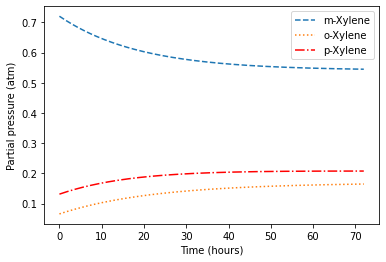

In [3]:
# Plotting partial pressure
plt.plot(tm,Pm,'--',tm,Po,':',tm,Pp,'r-.')
plt.legend(['m-Xylene','o-Xylene','p-Xylene'])
plt.xlabel('Time (hours)')
plt.ylabel('Partial pressure (atm)')

**<font color=blue>0 / 10 points</font> Part 4a:** It would be great to have a continuous function that approximates Q_data below. Use linear regression to fit a Fourier Sine Series to the dataset `Q_data` below using GEKKO's `m.sin` function and/or the numpy `np.sin` function to approximately describe this variable flow rate for weekdays. Take care when converting between 24-hour cycles and the $2\pi$ radians used in trig functions.

The Fourier Series is given by:

\begin{equation}
F(x) = c_0 + c_1*\sin(x) + c_2*\sin(2x) + c_3*\sin(3x) + c_4*\sin(4x) + ...
\end{equation}

Once your code is working, try different lengths of the Fourier Sine Series (no need to show your work for that part) to find something that fits the data reasonably (don't try anything longer than 8 terms). Pick a length and plot the continuous Fourier Sine Series alongside `Q_data`.

In [5]:
tm = np.linspace(0,23,24)
Q_data = [0.65,0.6,0.55,0.5,0.45,0.45,0.45,0.55,0.65,0.75,0.75,0.75,
          0.7,0.69,0.68,0.67,0.67,0.67,0.68,0.7,0.75,0.8,0.75,0.7]

# Convert from time to radian
xm = 2*np.pi/24*tm

m = GEKKO()
m.options.IMODE = 2

# Coefficient:
c = [m.FV(value=0) for i in range(6)]

x = m.Param(value=xm)

y = m.CV(value=Q_data)

y.FSTATUS = 1

# Equation for Fourier Sine series
m.Equation(y == c[0] + c[1]*m.sin(x) + c[2]*m.sin(2*x) 
           + c[3]*m.sin(3*x) + c[4]*m.sin(4*x) + c[5]*m.sin(5*x))

# Change status to allow solve to optimize
for i in range(6):
    c[i].STATUS = 1
    
# Solve
m.solve(disp=False)

# Get predicted value
x_smooth = np.linspace(0,xm[len(xm)-1],100)
Q_hat = np.ones(len(x_smooth))
for i in range(len(x_smooth)):
    Q_hat[i] = c[0].value[0] + c[1].value[0]*np.sin(x_smooth[i]) + c[2].value[0]*np.sin(2*x_smooth[i]) 
    + c[3].value[0]*np.sin(3*x_smooth[i]) + c[4]*np.sin(4*x_smooth[i]) + c[5]*np.sin(5*x_smooth[i]) 

# Coefficient of the regression
c_val = []
for i in range(6):
    c_val.append(c[i].value[0])


Text(0, 0.5, 'Flow rate (m^3/s)')

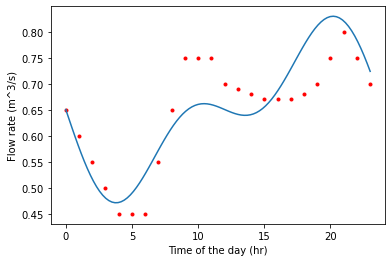

In [8]:
# Plot data and regression
plt.figure()
plt.plot(tm,Q_data,'r.')
plt.plot(x_smooth*24/(2*np.pi),Q_hat)
plt.xlabel('Time of the day (hr)')
plt.ylabel('Flow rate (m^3/s)')


**Part 4b:** A factory dumps a unique pollutant (it's not in the ordinary wastewater) into the plant between 9:00 am and 5:00 pm, with a flow rate of 10,000 gallons/hour (0.01 m$^3$/s). The concentration of this pollutant in the inlet stream is 5000 ppm, and it must be below 50 ppb when it leaves the wastewater plant.

Model this time-dependent series of reactors, keeping the volume in both treatment tanks constant at 500 m$^3$.
The rate constant for reaction is 0.9 hr$^{-1}$.

What is the maximum concentration of the pollutant leaving the plant?

How much of the pollutant is reacted in total? What fraction of the total amount is this?

**If you're confident in your solution to Part 4a, then use your smooth fitted function for the ordinary flow rate. If you're not confident in your solution to Part 4a, that's fine, use `Q_data` that I provided, instead (you'll just be stuck with 24 time points, no more).**

In [10]:
# initialize model 
m = GEKKO(remote=False)
m.time = np.linspace(0,24,25*50) # I want to model till the end of the day
t = m.Param(m.time*2*np.pi/24)

# define constants

k = m.Const(value = 0.9) #hr^-1
V = m.Const(value = 132086) #Gallons (equivalent to 500 m^3)

# define variables for optimization: concentration of tank 1 and tank 2
C = [] 
for i in range(2):
    C.append(m.Var(value=0))

# Parameter: Flow rate and concentration of pollutant during the day 
step = 9*50 # start at 9AM
Qin_step = np.zeros(len(t))
Qin_step[step:step+8*50] = 10000 #gallons/hr From 9AM to 5PM 
Qin = m.Param(value=Qin_step)

Cin_step = np.zeros(len(t))
Cin_step[step:step+8*50] = 5000 #ppm From 9AM to 5PM 
Cin = m.Param(value=Cin_step)

# Intermediate:
# total flow rate into first reactor
Q = m.Intermediate(Qin + (c_val[0] + c_val[1]*m.sin(t) 
                   + c_val[2]*m.sin(2*t) + c_val[3]*m.sin(3*t) 
                   + c_val[4]*m.sin(4*t) + c_val[5]*m.sin(5*t))*951019.2) #convert to gallon/hr because the model is in m3/s
# concentration of the pollutant in the feed stream
Cin_t = m.Intermediate(Cin*Qin/Q)

# define equation(s)
# First tank:
m.Equation(V*C[0].dt() == Q*Cin_t - k*V*C[0] - Q*C[0])

# Second tanks:
m.Equation(V*C[1].dt() == Q*C[0] - k*V*C[1] - Q*C[1]) 

# define solver and mode options 
m.options.IMODE=4
m.solve(disp=False)

# Concentration at the end of the day
Cout_1 = C[0].value[len(C[0])-1]
Cout_2 = C[1].value[len(C[1])-1]

# Calculate total mol reacted: amount = conc*flow rate* time
total_in = 0.01*8*3600*5000 # unit: gram

Cout = np.array(C[1].value[:])
ave_Cout = np.sum(Cout*24/(25*50))/24 #use Riemann sum to calculate average concentration 
total_out = 0.01*(24-9)*3600*ave_Cout # unit: gram

total_react = total_in - total_out

# At the end, print these results
print('End of day concentration \n\tin tank 1 is ', Cout_1, 'ppm \n\tin tank 2 is ', Cout_2, ' ppm')
print('Max outlet concentration is ', np.max(C[1].value[:]), ' ppm' )
print('Total amount reacted is ', total_react/1000000, 'ton' )
print('Fraction reacted is ', total_react/total_in )

## The outlet concentration at the rush hour is much higher than 50 ppb (more than a 1000 time!!!).


End of day concentration 
	in tank 1 is  3.5075285117e-19 ppm 
	in tank 2 is  1.3589916526e-17  ppm
Max outlet concentration is  57.088371808  ppm
Total amount reacted is  1.4302897140726591 ton
Fraction reacted is  0.9932567458837911


(0.0, 24.0, 0.0, 90.0)

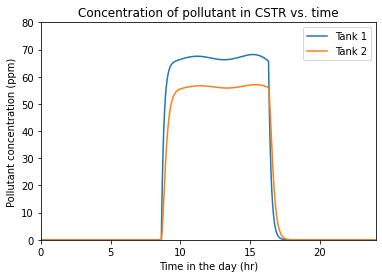

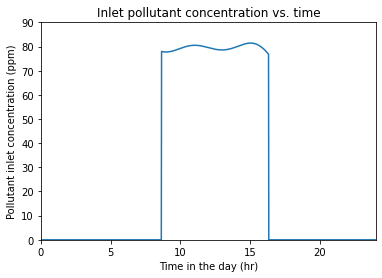

In [11]:
plt.figure(1)
plt.plot(m.time,C[0],m.time,C[1])
plt.legend(['Tank 1','Tank 2'])
plt.xlabel('Time in the day (hr)')
plt.ylabel('Pollutant concentration (ppm)')
plt.title('Concentration of pollutant in CSTR vs. time')
plt.axis([0,24,0,80])
plt.figure(2)
plt.plot(m.time,Cin_t)
plt.xlabel('Time in the day (hr)')
plt.ylabel('Pollutant inlet concentration (ppm)')
plt.title('Inlet pollutant concentration vs. time')
plt.axis([0,24,0,90])